In [73]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
mypath = "/content/drive/My Drive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
print(filenames)

['192_2b1_Al_mc_LittC2SE.wav', '192_2b2_Ar_mc_LittC2SE.wav', '192_2b3_Ar_mc_LittC2SE.wav', '192_2b3_Al_mc_LittC2SE.wav', '193_1b2_Al_mc_AKGC417L.wav', '193_1b2_Ar_mc_AKGC417L.wav', '193_1b2_Pr_mc_AKGC417L.wav', '193_1b2_Ll_mc_AKGC417L.wav', '193_1b2_Tc_mc_AKGC417L.wav', '193_1b2_Pl_mc_AKGC417L.wav', '193_1b4_Lr_mc_AKGC417L.wav', '193_7b3_Ll_mc_AKGC417L.wav', '193_7b3_Ar_mc_AKGC417L.wav', '193_7b3_Al_mc_AKGC417L.wav', '194_1b1_Lr_sc_Meditron.wav', '193_7b3_Pr_mc_AKGC417L.wav', '193_7b3_Tc_mc_AKGC417L.wav', '193_7b3_Lr_mc_AKGC417L.wav', '193_7b3_Pl_mc_AKGC417L.wav', '195_1b1_Al_sc_Litt3200.wav', '194_1b1_Pr_sc_Meditron.wav', '195_1b1_Lr_sc_Litt3200.wav', '195_1b1_Ll_sc_Litt3200.wav', '195_1b1_Ar_sc_Litt3200.wav', '195_1b1_Pr_sc_Litt3200.wav', '195_1b1_Pl_sc_Litt3200.wav', '197_1b1_Tc_sc_Meditron.wav', '197_1b1_Al_sc_Meditron.wav', '196_1b1_Pr_sc_Meditron.wav', '198_1b5_Ar_mc_AKGC417L.wav', '198_1b5_Lr_mc_AKGC417L.wav', '198_1b5_Al_mc_AKGC417L.wav', '198_1b5_Ll_mc_AKGC417L.wav', '198_1b5_

In [4]:
p_id_in_file = [] #환자 ID
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np. array(p_id_in_file)
#이름에서 3번째만 따로 빼서 리스트 구성

print(p_id_in_file)

[192 192 192 192 193 193 193 193 193 193 193 193 193 193 194 193 193 193
 193 195 194 195 195 195 195 195 197 197 196 198 198 198 198 198 198 198
 198 198 198 198 198 198 198 200 200 199 199 200 200 200 200 200 200 200
 200 200 200 200 200 200 200 200 200 200 200 200 200 201 200 201 201 202
 201 201 201 203 203 203 203 203 203 203 203 203 203 203 203 203 203 203
 203 203 203 203 203 203 204 204 204 204 204 204 204 204 205 205 205 204
 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 206
 206 207 206 207 207 207 207 207 207 207 207 207 207 207 207 207 207 207
 207 207 207 207 208 207 209 210 211 211 210 211 211 211 211 211 213 213
 211 212 213 213 213 213 213 213 213 213 213 213 213 213 213 213 213 214
 213 215 213 213 217 215 216 216 218 218 218 218 218 218 218 219 218 219
 219 219 219 220 221 221 221 220 221 221 221 221 221 221 221 221 222 223
 222 221 222 223 223 223 223 223 224 224 226 225 226 226 162 162 163 163
 163 163 163 163 163 163 163 163 163 163 164 163 16

In [12]:
max_pad_len = 862 #MFCC의 길이를 모두 같게 만들어 주기 위해서 

#예외 처리
def extract_features(file_name):
# 이 함수는 오디오 파일의 경로를 문자열로 입력하여 로드하고 오디오의 MFCC를 반환한다.
    try: 
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) #오디오 파일을 부동 소수점 시계열로 로드 (res_type=리셈플링 유형) 
                                                                                         #기본적으로 kaiser_best 사용,, 더 빠른 방법을 사용하려면 kaiser_fast 사용
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) #mfcc로 변환 
            # MFCC 시각화 코드
                #import matplotlib.pyplot as plt
                # fig, ax = plt.subplots()
                # img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
                # fig.colorbar(img, ax=ax)
                # ax.set(title='MFCC')
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print('Error encountered while parsing file:',file_name)
        return None

    return mfccs 


In [13]:
#full paths of files 
filepaths = [join(mypath, f) for f in filenames]

In [14]:
#라벨 읽어오기
p_diag = pd.read_csv('/content/drive/My Drive/archive/Respiratory_Sound_Database/patient_diagnosis.csv', header=None)

In [27]:
print(p_diag)
p_diag[1].value_counts()

       0          1
0    101       URTI
1    102    Healthy
2    103     Asthma
3    104       COPD
4    105       URTI
..   ...        ...
121  222       COPD
122  223       COPD
123  224    Healthy
124  225    Healthy
125  226  Pneumonia

[126 rows x 2 columns]


COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: 1, dtype: int64

In [16]:
labels = np.array([p_diag[p_diag[0]== x][1].values[0] for x in p_id_in_file]) 
# p_id_in_file -> 이름에서 3번째만 빼서 따로 리스트 만든 것
# 라벨과 리스트 따로 만든 것 합체

In [17]:
print(labels)

['COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'Healthy' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'Healthy' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'URTI' 'URTI'
 'Bronchiectasis' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'Bronchiectasis' 'COPD' 'Bronchiectasis' 'Bronchiectasis' 'Healthy'
 'Bronchiectasis' 'Bronchiectasis' 'Bronchiectasis' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD'
 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'COPD' 'Bronchiolitis'
 'Bronchiolitis'

In [18]:
features = [] 

# 각 사운드 파일을 반복하고 features 추출
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


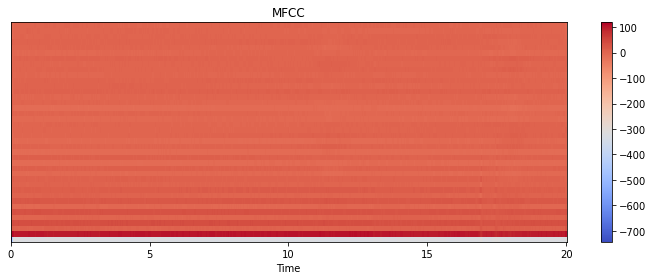

In [20]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [22]:
#추출한 features를 numpy 의 array 로 변환
features = np.array(features)
print(features)

[[[-5.17259187e+02 -5.13058195e+02 -5.15314719e+02 ... -5.29038794e+02
   -5.28941665e+02 -5.29989200e+02]
  [ 9.93634062e+01  1.03941020e+02  1.01698610e+02 ...  8.46115312e+01
    8.40610118e+01  8.20888171e+01]
  [ 6.91438608e+01  6.83392586e+01  6.66195762e+01 ...  5.61101855e+01
    5.48808300e+01  5.21112290e+01]
  ...
  [-2.41858069e+00 -7.95927245e-01  2.07767168e+00 ... -1.06362540e+00
    2.32516526e+00  3.64877290e+00]
  [-1.05235387e+00  1.63244822e+00  1.47337883e+00 ...  2.26676009e-01
    4.53220064e+00  6.66660206e+00]
  [ 3.33511448e+00  3.81668223e+00  1.52420671e+00 ...  3.93873664e+00
    5.00868971e+00  9.34757067e+00]]

 [[-4.24594942e+02 -4.61156218e+02 -4.78372498e+02 ... -4.27691741e+02
   -4.28817767e+02 -4.29058435e+02]
  [ 5.69529160e+01  8.07484102e+01  9.00518641e+01 ...  1.47509681e+02
    1.46670308e+02  1.44072208e+02]
  [ 8.12667734e+01  8.51934106e+01  7.46439915e+01 ...  9.82962098e+01
    9.91862445e+01  9.36788941e+01]
  ...
  [ 5.04141653e+00  9.9

In [28]:
#데이터 너무 없는 라벨들 제거 
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels=='LRTI'))[0], axis=0)
labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels=='LRTI'))[0], axis=0)


In [32]:
#print class counts 
unique_elements, counts_elements = np.unique(labels1, return_counts=True)

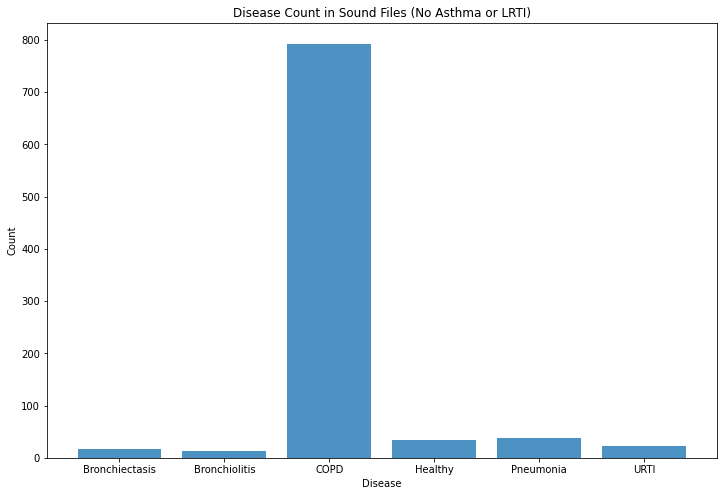

In [34]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.8)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [37]:
#원핫인코딩 
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels)
print(oh_labels)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [39]:
# CNN 에 채널 추가
features1 = np.reshape(features1, (*features1.shape,1))
print(features1)

[[[[[-5.17259187e+02]]

   [[-5.13058195e+02]]

   [[-5.15314719e+02]]

   ...

   [[-5.29038794e+02]]

   [[-5.28941665e+02]]

   [[-5.29989200e+02]]]


  [[[ 9.93634062e+01]]

   [[ 1.03941020e+02]]

   [[ 1.01698610e+02]]

   ...

   [[ 8.46115312e+01]]

   [[ 8.40610118e+01]]

   [[ 8.20888171e+01]]]


  [[[ 6.91438608e+01]]

   [[ 6.83392586e+01]]

   [[ 6.66195762e+01]]

   ...

   [[ 5.61101855e+01]]

   [[ 5.48808300e+01]]

   [[ 5.21112290e+01]]]


  ...


  [[[-2.41858069e+00]]

   [[-7.95927245e-01]]

   [[ 2.07767168e+00]]

   ...

   [[-1.06362540e+00]]

   [[ 2.32516526e+00]]

   [[ 3.64877290e+00]]]


  [[[-1.05235387e+00]]

   [[ 1.63244822e+00]]

   [[ 1.47337883e+00]]

   ...

   [[ 2.26676009e-01]]

   [[ 4.53220064e+00]]

   [[ 6.66660206e+00]]]


  [[[ 3.33511448e+00]]

   [[ 3.81668223e+00]]

   [[ 1.52420671e+00]]

   ...

   [[ 3.93873664e+00]]

   [[ 5.00868971e+00]]

   [[ 9.34757067e+00]]]]



 [[[[-4.24594942e+02]]

   [[-4.61156218e+02]]

   [[-4.78372498e+

In [41]:
#train test split 
x_train, x_test, y_train, y_test = train_test_split(features1,oh_labels, stratify=oh_labels, test_size=0.2, random_state=42)

In [43]:
num_rows= 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size=2

# 모델 구조
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model. add(MaxPool2D(pool_size=2))
model. add(Dropout(0.2))

model. add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model. add(MaxPool2D(pool_size=2))
model. add(Dropout(0.2))

model. add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model. add(MaxPool2D(pool_size=2))
model. add(Dropout(0.2))

model. add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model. add(MaxPool2D(pool_size=2))
model. add(Dropout(0.2))

model. add(GlobalAveragePooling2D())

model. add(Dense(num_labels, activation='softmax'))

In [44]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [58]:
model.summary()

score = model.evaluate(x_test,y_test,verbose=1)
accuracy=100*score[1]

print('Pre-training accuracy: %.4f%%' % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

In [62]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#train model 
num_epochs=250
num_batch_size=128

checkpoint_path = '/content/drive/My Drive/mymodel2_{epoch:02d}.h5'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=50, verbose=1)

start = datetime.now()
history = model.fit(x_train, y_train, batch_size= num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test), callbacks=[early_stopping_callback], verbose=1)
duration = datetime.now() - start
print('Training completed in time:',duration)

Epoch 1/250
6/6 [==============================] - 1s 126ms/step - loss: 0.0224 - accuracy: 0.9877 - val_loss: 0.4924 - val_accuracy: 0.8967
Epoch 2/250
6/6 [==============================] - 1s 106ms/step - loss: 0.0209 - accuracy: 0.9918 - val_loss: 0.5153 - val_accuracy: 0.8967
Epoch 3/250
6/6 [==============================] - 1s 107ms/step - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.5020 - val_accuracy: 0.9130
Epoch 4/250
6/6 [==============================] - 1s 109ms/step - loss: 0.0278 - accuracy: 0.9877 - val_loss: 0.6419 - val_accuracy: 0.8913
Epoch 5/250
6/6 [==============================] - 1s 107ms/step - loss: 0.0322 - accuracy: 0.9864 - val_loss: 0.4239 - val_accuracy: 0.8913
Epoch 6/250
6/6 [==============================] - 1s 109ms/step - loss: 0.0341 - accuracy: 0.9864 - val_loss: 0.7059 - val_accuracy: 0.8913
Epoch 7/250
6/6 [==============================] - 1s 109ms/step - loss: 0.0415 - accuracy: 0.9809 - val_loss: 0.4099 - val_accuracy: 0.9076
Epoch 8/250
6

In [63]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Training Accuracy:', score[1])

score = model.evaluate(x_test,y_test,verbose=0)
print('Testing Accuracy:', score[1])


Training Accuracy: 0.9536153078079224
Testing Accuracy: 0.885869562625885


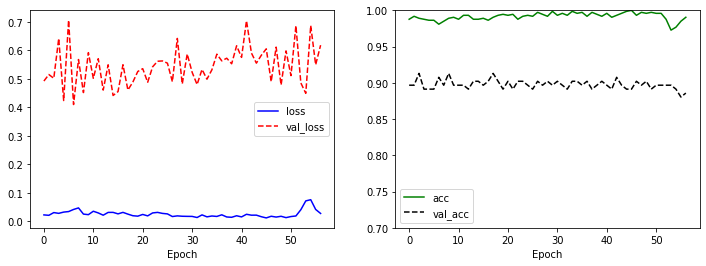

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.ylim([0.7, 1])
plt.legend()

plt.show()

In [71]:
# x_test 의 레이블 예측
preds = model.predict(x_test) 
print(preds)

# 예측한 레이블 argmax 돌려서 어느건지 예측
classpreds = np.argmax(preds, axis=1)
print(classpreds)

# 실제 y_test의 레이블
y_testclass = np.argmax(y_test,axis=1)
print(y_testclass)

n_classes=6

[[2.2250000e-09 1.3531522e-07 9.9999881e-01 5.1872462e-07 9.4926769e-09
  5.3191837e-07]
 [1.6920422e-10 2.6545763e-08 9.9979919e-01 2.3375945e-15 2.7403221e-05
  1.7342358e-04]
 [2.1922332e-13 5.8811645e-12 1.0000000e+00 2.8958425e-34 1.7595765e-11
  4.0983448e-08]
 ...
 [7.0480032e-06 3.3948368e-06 9.8799729e-01 1.8415804e-08 1.1982767e-02
  9.4303359e-06]
 [2.7298921e-13 4.8401136e-12 1.0000000e+00 1.7401999e-13 2.0924458e-17
  9.9498589e-14]
 [4.8025555e-07 1.0924289e-04 4.9503037e-06 6.5755657e-06 9.3750584e-01
  6.2372901e-02]]
[2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 4 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4]
[2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 3 2 2 2 3 4 2 2 2 2 2 2 3 2 2 0 2 2 2 2
 0 2 2 2 2 

In [75]:
# 각 class의 ROC curve와 ROC area 
pr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [76]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

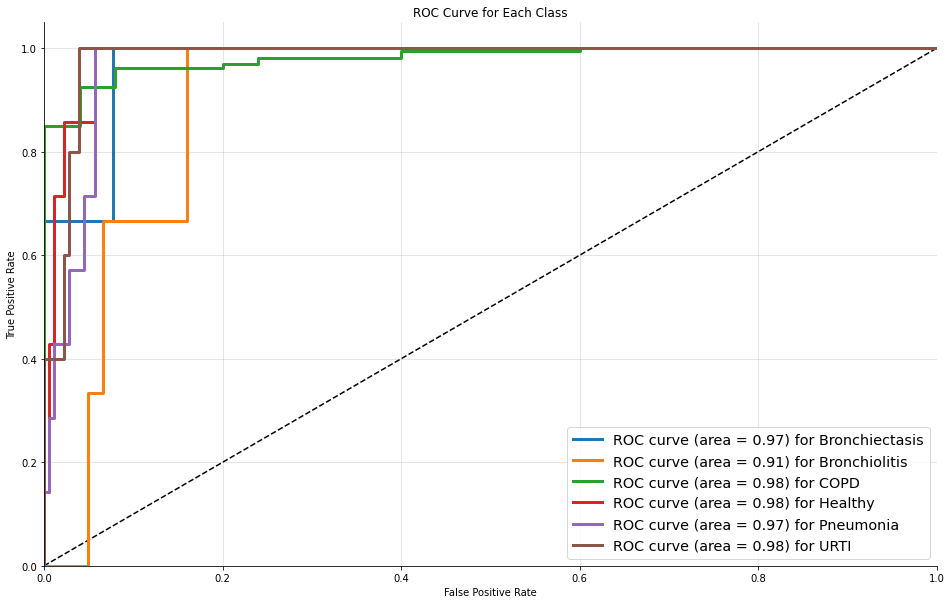

In [77]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [78]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.91      0.99      0.95       159
       Healthy       1.00      0.14      0.25         7
     Pneumonia       0.67      0.29      0.40         7
          URTI       0.33      0.40      0.36         5

      accuracy                           0.89       184
     macro avg       0.49      0.30      0.33       184
  weighted avg       0.86      0.89      0.86       184



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  0   0   3   0   0   0]
 [  0   0   2   0   1   0]
 [  0   0 158   0   0   1]
 [  0   0   3   1   0   3]
 [  0   0   5   0   2   0]
 [  0   1   2   0   0   2]]
